## For prototyping magic plots



In [1]:

'''This cell imports the necessary libraries and modules for the analysis.'''
import sys, os
from pathlib import Path

# Robustly ensure 'src' is on sys.path (works whether CWD is repo root or notebooks/)
for p in [Path.cwd(), *Path.cwd().parents]:
    cand = p / "src"
    if cand.exists():
        sys.path.insert(0, str(cand))
        break

import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Importing modules
from qft.udw_qutrits import detector_state      
from magic.wigner_polytope import wigner_inequalities
from utils.state_checks import is_valid_state, validate_and_print


plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{lmodern}",
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

# def partial_trace_second_qutrit(rho):
#     """Trace out the second qutrit from a 2-qutrit density matrix (9x9) to get a 3x3 reduced state.
#     Assumes Hilbert space ordering H = H_A ⊗ H_B with dims (3,3).
#     """
#     rho = np.asarray(rho)
#     rho = rho.reshape(3,3,3,3)  # (i_A, i_B, j_A, j_B)
#     # Trace over B (second qutrit): sum over i_B == j_B
#     red = np.einsum('ibja->ij', rho)
#     return red



def reduce_state(rho: np.ndarray) -> np.ndarray:
    """
    Partial trace over the second qutrit (B) of a 2-qutrit density matrix.

    Parameters
    ----------
    rho : np.ndarray
        9x9 density matrix for a 2-qutrit system (A⊗B), dtype complex recommended.

    Returns
    -------
    np.ndarray
        3x3 reduced density matrix for the first qutrit (A).
    """
    rho = np.asarray(rho)
    if rho.shape != (9, 9):
        raise ValueError("rho must be a 9x9 matrix for a 2-qutrit system.")

    # Reshape to indices [i_A, i_B, j_A, j_B]
    rho_reshaped = rho.reshape(3, 3, 3, 3)

    # Trace over B: sum over i_B == j_B
    rho_A = np.trace(rho_reshaped, axis1=1, axis2=3)  # shape (3,3)

    return rho_A


## Wigner negativity vs gap ($\Omega$)

[SU2, smeared] gap=0.333: violated points = [((np.int64(1), np.int64(0)), np.float64(-1.5038493176245504e-08)), ((np.int64(1), np.int64(2)), np.float64(-3.162366070226492e-09))]
[SU2, smeared] gap=0.667: violated points = [((np.int64(1), np.int64(0)), np.float64(-2.1167197435774063e-08)), ((np.int64(1), np.int64(2)), np.float64(-1.1114272878050923e-08))]
[SU2, smeared] gap=1: violated points = [((np.int64(1), np.int64(0)), np.float64(-2.0398689543640773e-08)), ((np.int64(1), np.int64(2)), np.float64(-1.2783949752759994e-08))]
[SU2, smeared] gap=1.33: violated points = [((np.int64(1), np.int64(0)), np.float64(-1.5903605490869752e-08)), ((np.int64(1), np.int64(2)), np.float64(-1.0742261926591534e-08))]
[SU2, smeared] gap=1.67: violated points = [((np.int64(1), np.int64(0)), np.float64(-1.0552826585251553e-08)), ((np.int64(1), np.int64(2)), np.float64(-7.422313468206333e-09))]
[SU2, smeared] gap=2: violated points = [((np.int64(1), np.int64(0)), np.float64(-6.0898628599460614e-09)), ((np.

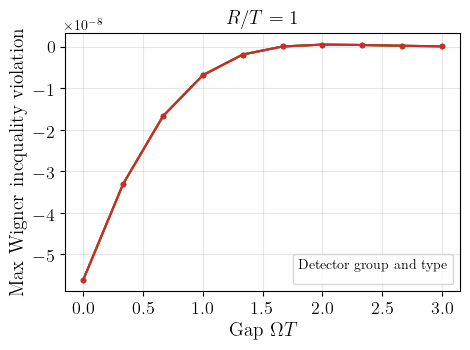

In [ ]:

'''This cell generates the plots for Wigner negativity vs gap for different detector types.'''


# Fixed parameters
switching = 1.0
separation = 1.0
smearing = 1
lam = 1e-3
regulator = 1
regularization = "magical"  # used by Q_term but detector_type/group decide which terms contribute

colors = ["#000000","#332288","#117733","#88CCEE","#DDCC77", "#CC6677", "#AA4499","#882255"]

group_types = [ 
                # ("SU2", "point_like"), 
                ("SU2", "smeared"),
                # ("HW", "smeared")
              ]
labels = {
    # ("SU2", "point_like"): "SU(2), point like",
    ("SU2", "smeared"): "SU(2), smeared",
    # ("HW", "smeared"): "HW, smeared"
}

plt.figure(figsize=(4.8,3.6))

# Sweep gaps
gaps = np.linspace(0.0, 3, 10)  # avoid zero to keep numerics well-behaved
deez = [0.1, 0.5, 1, 5]
linestyles = [ "--", "-.", ":", (0, (3, 1, 1, 1))]  # Add more if needed
for idx, d in enumerate(deez): 
    linestyle = linestyles[idx % len(linestyles)]
    for group, detector_type in group_types:
        wn_vals = []  # max violation per gap
        violated_points_list = []  # list of violating (i,j) points per gap
        for gap in gaps:
            rho = detector_state(
                gap=gap,
                switching=switching,
                separation=d,
                regulator=regulator,
                smearing=smearing,
                regularization=regularization,
                detector_type=detector_type,
                group=group,
                lam=lam,
            )
            if is_valid_state(rho):
                rho_1 = reduce_state(rho)  # reduce to first qutrit
                max_violation, violating_points, violation_sum = wigner_inequalities(rho_1, include_sum=True)
                value = np.log(max_violation/3 + (1 + rho[0, 0])/2)
                wn_vals.append(value)
                violated_points_list.append(violating_points)
                if max_violation > 0:
                    print(f"[{group}, {detector_type}] gap={gap:.3g}: violated points = {violating_points}")
            else:
                print("Invalid state detected at gap =", gap)
                validate_and_print(rho)
                break

        wn_vals = np.array(wn_vals)
        # label = f"d={d}"
        plt.plot(gaps[:len(wn_vals)], wn_vals, marker=".", lw=1.5)


plt.xlabel(r"{Gap} $\Omega T$",fontsize=14)
plt.ylabel(r"{Max Wigner inequality violation}",fontsize=14)
plt.title(rf"$R/T={smearing}$",fontsize=14)
# plt.title(rf"(a) $d/\sigma={separation}$, $R/\sigma={smearing}$, $\lambda={lam}$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend(title="Detector group and type")
plt.tight_layout()
# plt.savefig("wigner_negativity_vs_gap_different_models.pdf")
plt.show()

